### **本节尝试用pytorch框架实现简单卷积神经网络识别MNIST手写数据集**

In [2]:
# 导入
import torch
from mnist import load_mnist # 加载数据集


**一、在进行卷积神经网络构建前，先用torch实现一下SGD优化的全连接网络**

In [77]:
# 读取数据集
"""由于全连接，故图像需要展开，即不保留二维信息"""
(x_train,t_train),(x_test,t_test) = load_mnist(normalize = True,flatten = True,one_hot_label = True)
x_train = torch.tensor(x_train)
t_train = torch.tensor(t_train,dtype = torch.float32) # 注意统一数据类型类型
x_test = torch.tensor(x_test)
t_test = torch.tensor(t_test)

print(x_train.shape)
print(t_train.shape)

# 设置网络层参数
N,input_size = x_train.shape
output_size = 10 # 10个待识别的数字
H = 100

torch.Size([60000, 784])
torch.Size([60000, 10])


In [78]:
import matplotlib.pyplot as plt
import numpy as np

# 设置超参数
learning_rate = 0.1
iter_times = 10000
batch_size = 100

# 设置model
device = torch.device("cpu")
model = torch.nn.Sequential(
    torch.nn.Linear(input_size,H),
    torch.nn.ReLU(),
    torch.nn.Linear(H,output_size),
).to(device)

# 设置损失函数，均方误差
loss_fn = torch.nn.MSELoss(reduction = 'mean')

# 设置权重更新优化器optimizer
optimizer = torch.optim.SGD(model.parameters(),lr = learning_rate)

# 初始化train上的loss与accurancy
loss_train_plt = []
accurancy_train_plt = []

In [79]:

def train():
    loss_train_plt.clear()
    for i in range(iter_times):

        # 取mini-batch
        batch_mask = np.random.choice(x_train.shape[0],batch_size)
        x_batch = x_train[batch_mask]
        t_batch = t_train[batch_mask]

        # 网络计算
        y_pred = model(x_batch)
        loss = loss_fn(y_pred,t_batch)
        loss_train_plt.append(loss.item())
        # print(loss.item())
        # model.zero_grad() # 清空之前的梯度
        optimizer.zero_grad() # 清空之前的梯度
        loss.backward() # 反向传播

        # 更新权重参数
        optimizer.step()
        # with torch.no_grad():
        #     for param in model.parameters():
        #         param.data -= learning_rate * param.grad
        # print(f"times{i + 1} finish!")
train()

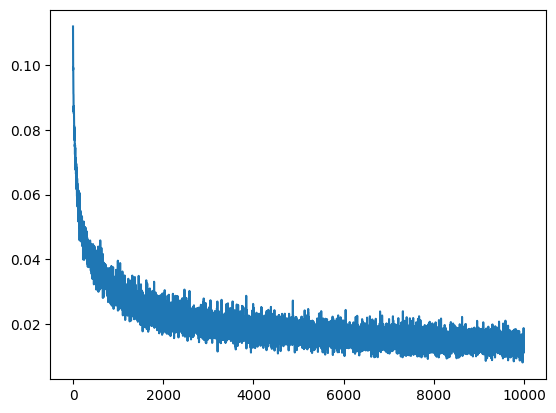

In [80]:
plt.plot(np.arange(0,iter_times,1),loss_train_plt)
plt.show()

In [81]:
# 测试准确度的
def check_accurancy(x,y,model):
    """x为输入，y为label,model为待测模型"""
    n = x.shape[0]
    pred = model(x)
    one_hot_pred = torch.argmax(pred,dim = 1)
    correct = torch.sum(one_hot_pred == torch.argmax(y,dim = 1))
    print(f"accurancy is : {correct / n}")


check_accurancy(x_train,t_train,model)
check_accurancy(x_test,t_test,model)

accurancy is : 0.955049991607666
accurancy is : 0.9545999765396118


**训练结果：trian与test上的准确率基本一致，故未发生过拟合**

**二、下面进行卷积神经网络的搭建——基于autograd手搓**

In [3]:
import torch.nn.functional as F
import matplotlib.pyplot as plt
import numpy as np

In [4]:
# 读取数据集
"""由于卷积，故图像不需要展开，保留图像的信息"""
(x_train,t_train),(x_test,t_test) = load_mnist(normalize = True,flatten = False,one_hot_label = True)
x_train = torch.tensor(x_train)
t_train = torch.tensor(t_train,dtype = torch.float32) # 注意统一数据类型类型
x_test = torch.tensor(x_test)
t_test = torch.tensor(t_test)

print(x_train.shape)
print(t_train.shape)

torch.Size([60000, 1, 28, 28])
torch.Size([60000, 10])


In [5]:
# 设置网络层参数
N,ch1,img_H,img_W = x_train.shape
ch2 = 30 ;F1H = 5 ;F1W = 5 ;F1P = 2 # 第一层卷积层的滤波器参数：输出通道、滤波器大小H与W、填充padding
affine1_in = ch2 * img_H * img_W;affine1_out = 100 # 全连接层1
affine2_out = t_train.shape[1] # 全连接层2(输出层)

**网络架构展示：**

$$data \rightarrow conv1 \rightarrow affine1 \rightarrow affine2 \rightarrow y\_pred$$

In [10]:
# 测试F
conv_w1 = torch.zeros((6, 3, 5, 5), dtype = torch.float32)  # [out_channel, in_channel, kernel_H, kernel_W]
conv_b1 = torch.zeros((6,))  # out_channel
x = torch.zeros((64, 3, 32, 32), dtype = torch.float32)  # minibatch size 64, image size [3, 32, 32]
print(x.shape)
x = F.conv2d(x,conv_w1,conv_b1,padding = 2) # padding = 2保持图像经滤波后的大小
print(x.shape)

torch.Size([64, 3, 32, 32])
torch.Size([64, 6, 32, 32])


In [6]:
# 初始化权重函数
def random_weight(shape):
    w = torch.rand(shape)
    w.requires_grad = True
    return w

conv_w1 = None
conv_b1 = None
affine1_w = None
affine1_b = None
affine2_w = None
affine2_b = None

conv_w1 = random_weight((ch2,ch1,F1H,F1W))
conv_b1 = random_weight(ch2)
affine1_w = random_weight((affine1_in,affine1_out))
affine1_b = random_weight(affine1_out)
affine2_w = random_weight((affine1_out,affine2_out))
affine2_b = random_weight(affine2_out)

params = [conv_w1, conv_b1, affine1_w, affine1_b, affine2_w, affine2_b]

plt_loss = []

In [7]:
def all_flatten(x):
    size = torch.tensor(x.shape)
    return x.view(torch.prod(size))

def three_layer_convnet(x,params):
    """三层卷积神经网络"""

    # 获取参数
    N = x.shape[0]
    conv_w1, conv_b1, affine1_w, affine1_b, affine2_w, affine2_b = params
    y_pred = None
    x = F.conv2d(x,weight = conv_w1,bias = conv_b1,padding = 2)
    x = F.relu(x)
    x = x.view(N,-1) # flatten操作
    x = x.mm(affine1_w) + affine1_b
    # x = torch.matmul(x,affine1_w) + affine1_b # 等价形式
    x = F.relu(x)
    x = x.mm(affine2_w) + affine2_b
    return x

def train(x,labels,model_fn,params,lr):
    """训练函数loop"""

    # 前向传播+损失计算
    y_pred = model_fn(x,params)
    loss = F.cross_entropy(y_pred,labels)
    plt_loss.append(loss.item())

    # 清空梯度
    for w in params:
        w.grad = None

    # 反向传播
    loss.backward()
    with torch.no_grad():
        for w in params:
            w -= lr * w.grad
    


0 finish!
1 finish!
2 finish!
3 finish!
4 finish!
5 finish!
6 finish!
7 finish!
8 finish!
9 finish!
10 finish!
11 finish!
12 finish!
13 finish!
14 finish!
15 finish!
16 finish!
17 finish!
18 finish!
19 finish!
20 finish!
21 finish!
22 finish!
23 finish!
24 finish!
25 finish!
26 finish!
27 finish!
28 finish!
29 finish!
30 finish!
31 finish!
32 finish!
33 finish!
34 finish!
35 finish!
36 finish!
37 finish!
38 finish!
39 finish!
40 finish!
41 finish!
42 finish!
43 finish!
44 finish!
45 finish!
46 finish!
47 finish!
48 finish!
49 finish!
50 finish!
51 finish!
52 finish!
53 finish!
54 finish!
55 finish!
56 finish!
57 finish!
58 finish!
59 finish!
60 finish!
61 finish!
62 finish!
63 finish!
64 finish!
65 finish!
66 finish!
67 finish!
68 finish!
69 finish!
70 finish!
71 finish!
72 finish!
73 finish!
74 finish!
75 finish!
76 finish!
77 finish!
78 finish!
79 finish!
80 finish!
81 finish!
82 finish!
83 finish!
84 finish!
85 finish!
86 finish!
87 finish!
88 finish!
89 finish!
90 finish!
91 finish

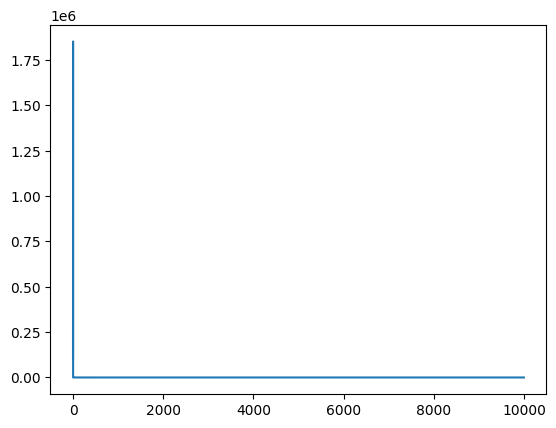

In [8]:
plt_loss = []
learning_rate = 1e-3
batch_size = 100
iter_times = 10000
for i in range(iter_times):

    # 取mini-batch
    batch_mask = np.random.choice(x_train.shape[0],batch_size)
    x_batch = x_train[batch_mask]
    t_batch = t_train[batch_mask]
    
    # 训练
    train(x_batch,t_batch,three_layer_convnet,params,lr = learning_rate)
    print(f"{i} finish!")

plt.plot(np.arange(0,iter_times,1),plt_loss)
plt.show()

In [20]:
# 测试准确度的
def check_accurancy_cnn(x,y,model,params):
    """x为输入，y为label,model为待测模型"""
    n = x.shape[0]
    pred = model(x,params)
    one_hot_pred = torch.argmax(pred,dim = 1)
    correct = torch.sum(one_hot_pred == torch.argmax(y,dim = 1))
    print(f"accurancy is : {correct / n}")


check_accurancy_cnn(x_train[0:200],t_train[0:200],three_layer_convnet,params)
check_accurancy_cnn(x_test[0:100],t_test[0:100],three_layer_convnet,params)

accurancy is : 0.10499999672174454
accurancy is : 0.07999999821186066


**效果不好，可能是网络有问题，或者参数初始化有问题!**

**三，下面进行卷积神经网络的搭建——基于nn**

In [31]:
import torch
import numpy as np
import matplotlib.pyplot as plt
from torch import nn

In [32]:
# 读取数据集
"""由于卷积，故图像不需要展开，保留图像的信息"""
(x_train,t_train),(x_test,t_test) = load_mnist(normalize = True,flatten = False,one_hot_label = True)
x_train = torch.tensor(x_train)
t_train = torch.tensor(t_train,dtype = torch.float32) # 注意统一数据类型类型
x_test = torch.tensor(x_test)
t_test = torch.tensor(t_test)

print(x_train.shape)
print(t_train.shape)

torch.Size([60000, 1, 28, 28])
torch.Size([60000, 10])


In [39]:
# 设置超参数
iter_times = 10000
batch_size = 100
learning_rate = 1e-3

# 定义模型
model = nn.Sequential(
    nn.Conv2d(1,6,5,padding = 2),
    nn.ReLU(),
    nn.Flatten(),
    nn.Linear(28 * 28 * 6,100),
    nn.ReLU(),
    nn.Linear(100,10)
)

# 定义优化器
optimizer = torch.optim.SGD(model.parameters(),lr = learning_rate,\
                        momentum = 0.9,nesterov = True)

# 定义损失函数
loss_cnn = torch.nn.MSELoss(reduce = 'mean')


In [40]:
plt_loss = []
def train_nn():
    plt_loss.clear()
    for i in range(iter_times):
        batch_mask = np.random.choice(x_train.shape[0],batch_size)
        train_batch = x_train[batch_mask]
        t_batch = t_train[batch_mask]
        y_pred = model(train_batch)
        loss = loss_cnn(y_pred,t_batch)
        plt_loss.append(loss.item())
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

In [41]:
train_nn()

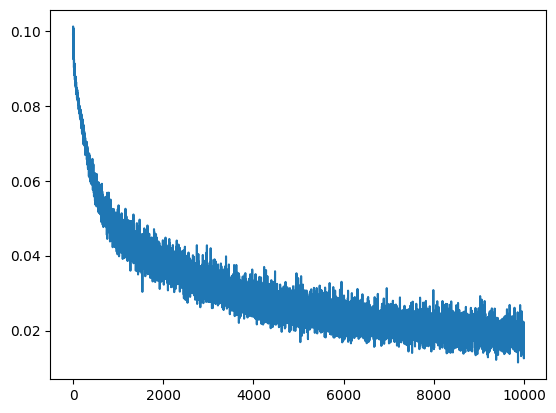

In [42]:
plt.plot(np.arange(0,len(plt_loss),1),plt_loss)
plt.show()

In [46]:
check_size = 1000
y_pred = model(x_train[0:check_size])
y_pred = torch.argmax(y_pred,dim = 1)
correct = torch.sum(y_pred == torch.argmax(t_train[0:check_size],dim = 1))
print(f"train accurancy:{correct/check_size}")
y_pred = torch.argmax(model(x_test[0:check_size]),dim = 1)
correct = torch.sum(y_pred == torch.argmax(t_test[0:check_size],dim = 1))
print(f"test accurancy:{correct/check_size}")

train accurancy:0.9350000023841858
test accurancy:0.9210000038146973


**同样的思路，自己用torch.function搭的不如nn，说明其中的参数初始化影响较大**